In [2]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    # Qwen2ForCausalLM
    # HuggingFaceEmbedding
)
import json
import time 
# import HuggingFaceEmbedding
import matplotlib.pyplot as plt
from transformers.modeling_attn_mask_utils import _prepare_4d_causal_attention_mask


/home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# model_name = "/data/llama-hf/Llama-2-13b-hf"
# model_name = "meta-llama/Llama-2-13b-hf"
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "Qwen/Qwen-72B"
local_dir="/data/models"

torch.cuda.empty_cache()

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)
device_map = {"": 0}
# Load model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
    # cache_dir = local_dir,
    pad_token_id=1,
    trust_remote_code = True
)

base_model.eval()

if "Qwen" in model_name:
    tokenizer = AutoTokenizer.from_pretrained(model_name, pad_token='<|extra_0|>', trust_remote_code=True)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, padding_side = 'right', truncation_side='right')
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# if "Llama-2" in model_name or "Mistral" in model_name:
#     # tokenizer.pad_token_id = tokenizer.bos_token_id
#     tokenizer.pad_token = tokenizer.bos_token
if tokenizer.pad_token_id == None:
    tokenizer.pad_token_id = 1

tokenizer.padding_side = "right"


The model is automatically converting to bf16 for faster inference. If you want to disable the automatic precision, please manually add bf16/fp16/fp32=True to "AutoModelForCausalLM.from_pretrained".
Try importing flash-attention for faster inference...



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda115.so
CUDA SETUP: CUDA runtime path found: /usr/lib/x86_64-linux-gnu/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 115
CUDA SETUP: Loading binary /home/hshapour/.pyenv/versions/3.10.12/envs/pytorch/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda115.so...


Loading checkpoint shards: 100%|██████████| 82/82 [01:27<00:00,  1.07s/it]


In [7]:
import datasets
from pathlib import Path
datasets.config.DOWNLOADED_DATASETS_PATH = Path("/home/ubuntu/data/.cache/huggingface")
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)

In [8]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

last_token_sim = []
Ns = 100
i = 0 
for data in dataset:
    i += 1
    if i < Ns+1:
        print(i, end='\r')
        # print(data)
        ex = data['text']
    else:
        break

    tokens = tokenizer(ex, return_tensors='pt')
    input_ids = tokens.input_ids.cuda()
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.cuda()

    embed_model = base_model.transformer.wte
    rotary_emb= base_model.transformer.rotary_emb
    input_embeds = embed_model(input_ids) 
    # input_embeds = rot_embed(input_embeds) 

    past_key_values_length = 0
    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (1, seq_length),
                input_embeds, past_key_values_length,
                )

    ntk_alpha_list = [1.0]
    rotary_emb._ntk_alpha_cached_list = ntk_alpha_list
    rotary_pos_emb_list = [
        rotary_emb(seq_length, ntk_alpha=ntk_alpha) for ntk_alpha in ntk_alpha_list
    ]

    similarity = []
    with torch.no_grad():
        x_old = input_embeds

        for idx, block in enumerate(base_model.transformer.h):
            x_new = block(x_old, attention_mask=attention_mask, rotary_pos_emb_list=rotary_pos_emb_list )[0]
            # similiarity.append(cos(x_new,x_old).cpu())
            similarity.append(cos(x_new[:,-1,:].to(torch.float32),x_old[:,-1,:].to(torch.float32)).cpu())
            x_old = x_new
        x = base_model.transformer.ln_f(x_new)
        x = base_model.lm_head(x)

    # print(x.shape)
    # similiarity = torch.stack(similiarity).squeeze()
    last_token_sim.append(similarity)

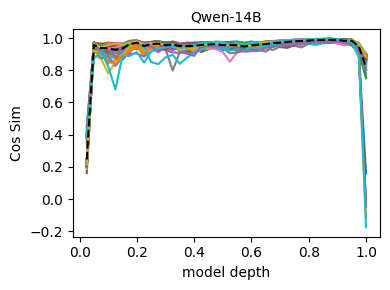

In [9]:
last_token_sim = torch.tensor(last_token_sim)
num_layers = len(base_model.transformer.h)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(1,num_layers+1)/num_layers, last_token_sim.T)
plt.plot(torch.arange(1,num_layers+1)/num_layers, last_token_sim.mean(dim=0),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

In [8]:
ex1 = """The woman who died after falling from a bridge over the A21 has been identified as a Sevenoaks mum. Marta Kendle, 37, fell from the Gracious Lane bridge on the morning of February 19. Police were called to the carriageway around 6.10am and the road was promptly closed in both directions. Despite paramedics best efforts, Marta, who was originally from Poland, was pronounced dead at the scene. Kent and Medway Coroners office have confirmed an inquest into her death will open on Wednesday (February 27). Tributes to the mum were left at the scene and on social media. Friend, Jodi Cahill posted on Facebook: "I will certainly remember you. I am sorry we did not see how lost and alone you felt. "Be at peace dear Marta." A floral tribute left at the scene said goodbye to the "beautiful and kind soul". It read: "To a beautiful and kind soul, we are sorry we didn&apos;t see your pain. We will miss you always. "Rest in peace Marta, Love from Lorraine, Colin and family." The inquest will take place at the Archbishop&apos;s Palace in Maidstone and will examine the circumstances surrounding Mrs Kendle&apos;s death. Are you struggling or know someone who is? Watch our video below to find out how the Samaritans could help. Mrs Kendle&apos;s death prompted the setting up of a petition calling for higher railings along the Gracious Lane bridge by Sevenoaks Common - to prevent people falling and to protect drivers from below. By today (February 25) 4,500 people had signed. The same site was the scene of another death in July last year when Southborough woman, Angela Skinner, 54, also died after falling on to the A21."""
# ex = "hello world"
ex2 = "ABC is a startup based in New York City and Paris"
ex = [ex1,ex2]
tokens = tokenizer(ex, return_tensors='pt')
input_ids = tokens.input_ids.cuda()
print(input_ids.shape)
seq_length = input_ids.size(1)
attention_mask = tokens.attention_mask.cuda()

embed_model = base_model.transformer.wte
rotary_emb= base_model.transformer.rotary_emb
input_embeds = embed_model(input_ids) 
# input_embeds = rot_embed(input_embeds) 

past_key_values_length = 0
attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, (1, seq_length),
            input_embeds, past_key_values_length,
            )

ntk_alpha_list = [1.0]
rotary_emb._ntk_alpha_cached_list = ntk_alpha_list
rotary_pos_emb_list = [
    rotary_emb(seq_length, ntk_alpha=ntk_alpha) for ntk_alpha in ntk_alpha_list
]

cos = torch.nn.CosineSimilarity(dim=2, eps=1e-6)
similiarity = []
with torch.no_grad():
    # x = base_model.transformer(input_ids)[0]

    x_old = input_embeds
    # x_old = base_model.transformer.rotary_emb(input_embeds)
    # x = base_model.transformer(input_ids=input_ids)[0]
    # x = base_model.transformer(inputs_embeds=x_old)[0]
    for idx, block in enumerate(base_model.transformer.h):
        x_new = block(x_old, attention_mask=attention_mask, rotary_pos_emb_list=rotary_pos_emb_list )[0]
        # similiarity.append(cos(x_new,x_old).cpu())
        # similarity.append(cos(x_new[row_indices,last_token,:].to(torch.float32),x_old[row_indices,last_token,:].to(torch.float32)).cpu())
        x_old = x_new
    x = base_model.transformer.ln_f(x_new)
    x = base_model.lm_head(x)
print(x.shape)
# similiarity = torch.stack(similiarity).squeeze()
with torch.no_grad():
    y = base_model(input_ids).logits
print(torch.allclose(x,y))
# print(torch.norm(x-y,dim=-1))
# print(y)
# print(y.shape)

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).

In [6]:
print(base_model)

QWenLMHeadModel(
  (transformer): QWenModel(
    (wte): Embedding(152064, 8192)
    (drop): Dropout(p=0.0, inplace=False)
    (rotary_emb): RotaryEmbedding()
    (h): ModuleList(
      (0-79): 80 x QWenBlock(
        (ln_1): RMSNorm()
        (attn): QWenAttention(
          (c_attn): Linear4bit(in_features=8192, out_features=24576, bias=True)
          (c_proj): Linear4bit(in_features=8192, out_features=8192, bias=False)
          (core_attention_flash): FlashSelfAttention()
          (attn_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): RMSNorm()
        (mlp): QWenMLP(
          (w1): Linear4bit(in_features=8192, out_features=24576, bias=False)
          (w2): Linear4bit(in_features=8192, out_features=24576, bias=False)
          (c_proj): Linear4bit(in_features=24576, out_features=8192, bias=False)
        )
      )
    )
    (ln_f): RMSNorm()
  )
  (lm_head): Linear(in_features=8192, out_features=152064, bias=False)
)


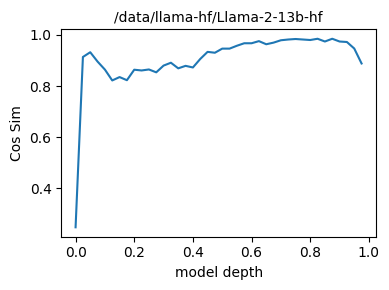

In [13]:
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, similiarity)
# plt.plot(torch.arange(num_layers)/num_layers, similiarity[:,1:].mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"test_{model_name.split('/')[-1]}.png")
plt.show()

## Efficient

In [9]:
from torch.utils.data import DataLoader
######## dataset import ########
dataset = load_dataset('c4',name = 'en', split='validation', streaming=True)

def collate_fn(examples):
    prompts = [example['text'] for example in examples]
    return {'input': prompts}

BATCH_SIZE = 1
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)



In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_batches = 100
step_list = torch.arange(1,65)

similarity = {}
for step in step_list:
    similarity[f"{step}"] = []

tic = time.time()
last_token_sim = []
i = 0 
for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break

    cutoff_len = 2000
    #  max_length=cutoff_len
    skip = False
    for text in batch['input']:
        # print(len(text.split(' ')))
        if len(text.split(' '))> cutoff_len:
            skip = True
            print(i, ' skipped')

    if skip:
        continue

    tokens = tokenizer(batch['input'], padding = True, truncation=True , return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    embed_model = base_model.transformer.wte
    rotary_emb= base_model.transformer.rotary_emb
    input_embeds = embed_model(input_ids) 

    past_key_values_length = 0
    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (1, seq_length),
                input_embeds, past_key_values_length,
                )

    ntk_alpha_list = [1.0]
    rotary_emb._ntk_alpha_cached_list = ntk_alpha_list
    rotary_pos_emb_list = [
        rotary_emb(seq_length, ntk_alpha=ntk_alpha) for ntk_alpha in ntk_alpha_list
    ]

    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)


    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    num_layers = len(base_model.transformer.h)
    # print(num_layers)
    x = input_embeds
    x_list = []
    x_list.append(x[row_indices,last_token,:].to(torch.float32).cpu())
    with torch.no_grad():
        for idx, block in enumerate(base_model.transformer.h):
            x = block(x, attention_mask=attention_mask, rotary_pos_emb_list=rotary_pos_emb_list )[0]
            x_list.append(x[row_indices,last_token,:].to(torch.float32).cpu())

    for step in step_list:
        sim_layer = []
        for idx in range(num_layers-step+1):
            # print("cos: ", cos(x_list[idx],x_list[idx+step]).shape)
            sim_layer.append(cos(x_list[idx],x_list[idx+step]))
        sim_layer = torch.stack(sim_layer,dim=1)
        # print("sim_layer: ", sim_layer.shape)
        similarity[f"{step}"].append(sim_layer)

for step in step_list:
    similarity[f"{step}"]= torch.cat(similarity[f"{step}"], dim=0)
    # print(similarity[f"{step}"].shape)
        
    # # x = base_model.model.norm(x_new)
    # # x = base_model.lm_head(x)
    # similarity = torch.stack(similarity).squeeze()
    # # print("sim:", similarity.shape)
    # last_token_sim.append(similarity)

    # if i % 10 == 0 :
    #     out_dir = "data/"
    #     fname = out_dir+ f"c4_{model_name.split('/')[-1]}_s_{step}_eff.json"
    #     last_token_sim_save= torch.cat(last_token_sim, dim = 1).tolist()
    #     with open(fname, 'w') as f:
    #         json.dump(last_token_sim_save, f)

toc = time.time()

# print("last_token_sim:", last_token_sim.shape)
print(f"Elapsded time: {toc-tic}")



90  skipped
Elapsded time: 120.43349933624268


In [1]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.viridis(np.linspace(0,1,1+len(step_list)))
x_min = []
y_min = []
plt.figure()#figsize=(5,2))
for step in step_list:
    # if step==1:
    #     fname = out_dir+ f"c4_{model_name.split('/')[-1]}_2.json"
    # else:
    #     fname = out_dir+ f"c4_{model_name.split('/')[-1]}_s_{step}_2.json"
    # last_token_sim_step =  file_reader(fname)
    x = np.arange(num_layers-step+1)
    y =  np.arccos(similarity[f"{step}"].detach().numpy()).mean(axis=0)/np.pi
    idx_min = np.argmin(y)
    x_min.append(x[idx_min])
    y_min.append(y[idx_min])
    # if step == num_layers//2:
    #     plt.plot(x, y,"r.-", markersize=3,linewidth=1.5,label=f"{step}")
    # else:
    # plt.plot(x, y,".-", markersize=3,linewidth=1.5,color=colors[step],label=f"{step}")
    # plt.plot(x, y,".-", markersize=3,linewidth=1.5,label=f"{step}")
    if step == num_layers//2:
        plt.plot(x, y,"r.-", markersize=3,linewidth=1.5,label=f"{step}")
    else:
        plt.plot(x, y,".-", markersize=3,linewidth=1.5,color=colors[step],label=f"{step}")

plt.plot(x_min,y_min,"kx-",markersize=4,alpha=0.5)
plt.xlabel("Layer Number")# (similarity btw in and out of [x,x+1,x+2])")
plt.ylabel("Angular Distance")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
# plt.grid()
# plt.xlim(15.5,27.5)
# plt.ylim(0.05,0.25)
# plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()

NameError: name 'step_list' is not defined

In [18]:
print(x_min)

[8, 30, 30, 30, 30, 30, 30, 30, 30, 30, 28, 28, 27, 27, 26, 27, 26, 26, 25, 25, 24, 24, 23, 22, 22, 21, 4, 3, 4, 3, 2, 3, 4, 3, 3, 3, 3, 2, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2]


## parallelized

In [1]:
from torch.utils.data import DataLoader
import datasets
dataset = datasets.load_dataset('c4',name = 'en', split='validation', streaming=True)
# dataset = datasets.load_dataset('garage-bAInd/Open-Platypus', streaming=True)

def collate_fn(examples):
    prompts = [example['text'] for example in examples]
    return {'input': prompts}

BATCH_SIZE = 4
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [3]:
i = 0 
for batch in data_loader:
    i += 1
    if i == 51:
        break

for text in batch['input']:
    print(len(text.split(' ')))

963
230
8925
100


In [4]:
device = "cuda"
last_token_sim = []
num_batches = 100
i = 0 
for batch in data_loader:
    i += 1
    if i < num_batches+1:
        print(i, end='\r')
        # print(batch['input'])
        # print(len(batch['input']))
    else:
        break
        
    tokens = tokenizer(batch['input'], padding=True, truncation=True, return_tensors='pt')
    input_ids = tokens.input_ids.to(device=device)
    # print(input_ids.shape)
    seq_length = input_ids.size(1)
    attention_mask = tokens.attention_mask.to(device=device)

    input_embeds = base_model.model.embed_tokens(input_ids) 

    attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, (BATCH_SIZE, seq_length),
                input_embeds, 0)
    
    input_embeds = base_model.model.embed_tokens(input_ids) 

    ### Getting the position of the last non-padding token
    ones = tokenizer.pad_token_id * torch.ones_like(input_ids)
    last_token = input_ids == ones
    row_indices = torch.arange(input_ids.size(0))
    last_token = (torch.sum(last_token, dim = 1) + 1) * (-1)


    # Extra 1 from BoS and the beginning of each string.
    if tokenizer.bos_token_id == 1:
        last_token+=1

    # print(row_indices, last_token)
    # print("Last token is", tokenizer.decode(input_ids[row_indices, last_token]))
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

    similarity = []
    with torch.no_grad():
        x_old = input_embeds
        for idx, block in enumerate(base_model.model.layers):
            # print(x_old.shape)
            # print(x_new[row_indices,last_token,:].shape)
            x_new = block(x_old,attention_mask=attention_mask)[0]
            # similiarity.append(cos(x_new,x_old).cpu())
            similarity.append(cos(x_new[row_indices,last_token,:],x_old[row_indices,last_token,:]).cpu())
            x_old = x_new
        x = base_model.model.norm(x_new)
        x = base_model.lm_head(x)
    similarity = torch.stack(similarity).squeeze()
    # print("sim:", similarity.shape)
    last_token_sim.append(similarity)


last_token_sim = torch.cat(last_token_sim, dim = 1)
print("last_token_sim:", last_token_sim.shape)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 45.73 GiB (GPU 0; 22.19 GiB total capacity; 8.31 GiB already allocated; 7.64 GiB free; 13.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

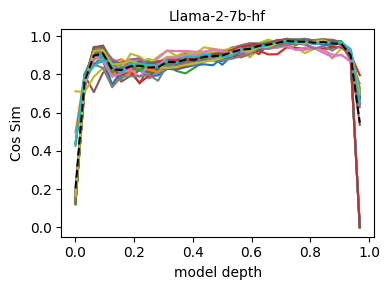

In [ ]:
num_layers = len(base_model.model.layers)
plt.figure(figsize=(4,3))
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim)
plt.plot(torch.arange(num_layers)/num_layers, last_token_sim.mean(dim=1),"k--")
plt.xlabel("model depth")
plt.ylabel("Cos Sim")
plt.title(f"{model_name.split('/')[-1]}", fontsize= 10)
plt.tight_layout()
# plt.savefig(f"c4_{model_name.split('/')[-1]}.png")
plt.show()